# **Tech Challenge - Data Viz - 4ª Fase**

## **1 - Introdução**

- A análise visa realizar a previsão dos valores futuros de fechamento do período diário da IBOVESPA através de algoritmos de machine learning.

  ## **2 - 	Objetivo Geral**

Realizar a análise exploratória robusta em busca de aprimorar o entendimento dos dados, criar um modelo preditivo através de algoritmos de machine learning com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

 E com base na análise demonstrar para o time de investimentos os seguintes pontos:
- O modelo com o storytelling, desde a captura do dado até a entrega do modelo.
- Justificar a técnica utilizada.
- Atingir uma acuracidade adequada (acima de 70%).

## **3 - Material e Ferramentas**

Embasando na robustez deste relatório, a base de dados utilizados nesta análise foi extraída da fonte do site da investing, sugerido para este trabalho com o período diário e com um intervalo de 20 anos assim atingindo uma maior acuracidade no modelo preditivo.

Para a análise foram usadas ferramentas de suma importância no cenário de análise de dados, tais como: Google Colab, Python.

## 4 - Importação dos dados

### 4.1 - Bibliotecas

In [ ]:
# Instalação bibliotecas necessarias

%pip install requests beautifulsoup4 pandas
%pip install statsforecast
%pip install pmdarima
%pip install -U scikit-learn
%pip install plotly==5.24.1
%pip install prophet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importando bibliotecas necessarias
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score


from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as ticker


from prophet import Prophet
from prophet.plot import plot_plotly


### 4.2 - Import base de dados

- Importando o DataSet direto da pagina do IPEA

In [ ]:
# URL da página do ipeadata
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"

# Fazendo a requisição HTTP para a página
response = requests.get(url)

# Verificando o status da requisição
if response.status_code == 200:
    print("Conexão bem-sucedida!")
else:
    print(f"Erro ao acessar a página: {response.status_code}")

# Parseando o HTML com BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Buscando a tabela na página
table = soup.find("table", {"class": "dxgvTable"})  # Identifique a classe correta da tabela
if table:
    # Extraindo os dados da tabela
    rows = table.find_all("tr")
    data = []

    # Iterando pelas linhas da tabela
    for row in rows:
        cols = row.find_all("td")
        cols = [col.text.strip() for col in cols]
        if cols:  # Ignorar linhas vazias
            data.append(cols)

    # Convertendo os dados para um DataFrame do pandas
    columns = ["Data", "Preço","drop1","drop2","drop3","drop4"]  # Ajuste conforme as colunas da tabela
    df_dados = pd.DataFrame(data, columns=columns)

    # Deletando as colunas
    df_dados = df_dados.drop(columns=["drop1","drop2","drop3","drop4"])

    # Deletando as 3 primeiras linhs
    df_dados = df_dados.iloc[3:]

    # Exibindo os primeiros e ultimos registros
    print(df_dados)

    # Salvando os dados em um arquivo CSV
    df_dados.to_csv("dados_petroleo.csv", index=False)
    print("Dados salvos em 'dados_petroleo.csv'.")
else:
    print("Tabela não encontrada na página.")


Conexão bem-sucedida!
             Data  Preço
3      25/11/2024  74,27
4      22/11/2024  76,10
5      21/11/2024  75,09
6      20/11/2024  74,33
7      19/11/2024  74,32
...           ...    ...
11305  26/05/1987  18,63
11306  25/05/1987  18,60
11307  22/05/1987  18,55
11308  21/05/1987  18,45
11309  20/05/1987  18,63

[11307 rows x 2 columns]
Dados salvos em 'dados_petroleo.csv'.


In [ ]:
#DataFrame df_dados
df_dados

Data  Preço
3      25/11/2024  74,27
4      22/11/2024  76,10
5      21/11/2024  75,09
6      20/11/2024  74,33
7      19/11/2024  74,32
...           ...    ...
11305  26/05/1987  18,63
11306  25/05/1987  18,60
11307  22/05/1987  18,55
11308  21/05/1987  18,45
11309  20/05/1987  18,63

[11307 rows x 2 columns]

In [ ]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11307 entries, 3 to 11309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    11307 non-null  object
 1   Preço   11307 non-null  object
dtypes: object(2)
memory usage: 176.8+ KB


## 5 - Analise exploratória  e Tratamento dos Dados

In [ ]:
# Renomeando as colunas
df_ipea = df_dados.rename(columns={"Data": "data", "Preço": "preco"})

# Convertendo a coluna 'data' para o tipo datetime
df_ipea["data"] = pd.to_datetime(df_ipea["data"], format="%d/%m/%Y")

# Convertendo a coluna 'preco' para float
df_ipea['preco'] = df_ipea['preco'].str.replace(',', '.').astype(float)


In [ ]:
df_ipea

data  preco
3     2024-11-25  74.27
4     2024-11-22  76.10
5     2024-11-21  75.09
6     2024-11-20  74.33
7     2024-11-19  74.32
...          ...    ...
11305 1987-05-26  18.63
11306 1987-05-25  18.60
11307 1987-05-22  18.55
11308 1987-05-21  18.45
11309 1987-05-20  18.63

[11307 rows x 2 columns]

In [ ]:
df_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11307 entries, 3 to 11309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11307 non-null  datetime64[ns]
 1   preco   11307 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 176.8 KB


In [ ]:
print("Quantidade de linhas e colunas: ", df_ipea.shape)

Quantidade de linhas e colunas:  (11307, 2)


In [ ]:
print("Estatísticas descritivas: ")
df_ipea.describe()

Estatísticas descritivas: 


data         preco
count                          11307  11307.000000
mean   2006-10-26 14:16:12.353409536     53.339940
min              1987-05-20 00:00:00      9.100000
25%              1998-07-07 12:00:00     20.630000
50%              2007-06-04 00:00:00     48.960000
75%              2015-04-03 12:00:00     76.770000
max              2024-11-25 00:00:00    143.950000
std                              NaN     33.151598

In [ ]:
print("Valores Nulos: ")
df_ipea.isna().sum()

Valores Nulos: 


data     0
preco    0
dtype: int64

In [ ]:
print("Valores Duplicados: ")
df_ipea.duplicated().sum()

Valores Duplicados: 


0

In [ ]:
# Setando data como INDEX
df_ipea = df_ipea.set_index('data')

# Preenchendo os dias faltantes (FDS + Feriados)
df_ipea = df_ipea.asfreq('D').ffill()

### 5.1 - Observando a incerteza politica nos meses/anos de eleições presidências


Incerteza Política: As eleições geralmente trazem incerteza política, o que pode afetar os mercados financeiros, incluindo o mercado de petróleo. Investidores podem ser mais cautelosos e retraindos, levando a flutuações nos preços.

Desde a proclamação da República em 1889, o Brasil teve várias eleições presidenciais. As eleições diretas ocorreram nos seguintes anos: 1891, 1894, 1898, 1902, 1906, 1910, 1914, 1918, 1922, 1926, 1930, 1945, 1950, 1955, 1960, 1989, 1994, 1998, 2002, 2006, 2010, 2014, 2018 e 2022.

As eleições presidenciais no Brasil geralmente ocorrem no mês de outubro. Portanto, os meses que antecedem a votação são julho, agosto e setembro. Durante esses meses, é comum haver um aumento na atividade política, com campanhas eleitorais intensificadas e debates entre os candidatos.

In [ ]:
df_dados_transformados =  df_ipea.reset_index()

In [ ]:
# Criando novas colunas ano, mes, dia

df_dados_transformados['ano'] = df_dados_transformados['data'].dt.year
df_dados_transformados['mes'] = df_dados_transformados['data'].dt.month
df_dados_transformados['dia'] = df_dados_transformados['data'].dt.day

In [ ]:
anos_eleicoes = [1989, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]
meses_eleicoes = [7, 8, 9,10]

In [ ]:
#Setando o período eleitoral aos meses

def periodo_eleitoral(row):
    if row['ano'] in anos_eleicoes and row['mes'] in meses_eleicoes:
        return 1
    else:
        return 0

df_dados_transformados['periodo_eleitoral'] = df_dados_transformados.apply(periodo_eleitoral, axis=1)

In [ ]:
#Setando o período ano eleitoral
def ano_eleitoral(row):
    if row['ano'] in anos_eleicoes:
        return 1
    else:
        return 0

df_dados_transformados['ano_eleitoral'] = df_dados_transformados.apply(ano_eleitoral, axis=1)

In [ ]:
# Atualizar o preço médio dos dados do mês e ano específico
def atualizar_preco_medio_3_anos(df, ano, mes, novo_preco):
    """
    Atualiza o preço médio para um mês e ano específicos no DataFrame.

    Args:
        df: DataFrame com as colunas 'ano', 'mes' e 'preco_medio'.
        ano: O ano para o qual atualizar o preço médio.
        mes: O mês para o qual atualizar o preço médio.
        novo_preco: O novo preço médio.
    """

    # Encontre as linhas correspondentes ao ano e mês especificados
    linhas_a_atualizar = (df['ano'] == ano) & (df['mes'] == mes)

    # Verifique se há linhas correspondentes
    if linhas_a_atualizar.any():
        # Atualize a coluna 'preco_medio' nas linhas encontradas
        df.loc[linhas_a_atualizar, 'media_3_anos'] = novo_preco
    else:
        print(f"Nenhuma linha encontrada para o ano {ano} e mês {mes}.")

In [ ]:
# Adicionando o preço médio por mês

df_preco_medio = df_dados_transformados.groupby(['ano', 'mes'])['preco'].mean().reset_index()
df_preco_medio = df_preco_medio.rename(columns={'preco': 'preco_medio'})
df_dados_transformados = pd.merge(df_dados_transformados, df_preco_medio, on=['ano', 'mes'])

In [ ]:
# Utilizando somente os meses eleitorais de todos os anos
df_meses_eleicao = df_dados_transformados[df_dados_transformados['mes'].isin(meses_eleicoes)]
df_meses_eleicao = df_meses_eleicao[["data", "preco"]]
df_meses_eleicao.set_index('data', inplace=True)
df_meses_eleicao = df_meses_eleicao.resample('D').asfreq().fillna(0)

Decompondo


In [ ]:
media_movel = df_meses_eleicao_decom = seasonal_decompose(df_meses_eleicao['preco'], model='additive').trend.to_frame()
sazonalidade = df_meses_eleicao_decom = seasonal_decompose(df_meses_eleicao['preco'], model='additive').seasonal.to_frame()
residuo      = df_meses_eleicao_decom = seasonal_decompose(df_meses_eleicao['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_meses_eleicao.index, y = df_meses_eleicao.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent) - Período eleitoral',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

**Ruído no Gráfico**

O ruído no gráfico (representado pela linha amarela) refere-se às variações aleatórias e imprevisíveis nos dados que não podem ser explicadas pelos componentes de tendência ou sazonalidade. Este componente captura as flutuações que ocorrem devido a fatores aleatórios ou eventos não sistemáticos.

No gráfico, o ruído parece ter uma amplitude relativamente constante ao longo do tempo, com algumas variações mais pronunciadas em certos períodos. A análise do ruído é importante para entender a variabilidade inerente aos dados e para melhorar a precisão dos modelos de previsão, isolando os componentes sistemáticos (tendência e sazonalidade) das flutuações aleatórias.

Abaixo trataremos os dados podendo observar o rúido nos meses de período eleitora e vamos comparar

In [ ]:
# prompt: utilizando o df_dados_transformados efetuar a media dos tres anos que antecedem cada ano_eleitoral

# Calculate the 3-year rolling average before each election year
df_dados_transformados['media_3_anos'] = 0  # Initialize the column

In [ ]:
for ano in anos_eleicoes:
    #if ano == 2022:
    # Get the indices for the current election year
    election_year_indices = df_dados_transformados[df_dados_transformados['ano'] == ano].index

    # Calculate the start and end years for the 3-year rolling window
    start_year = ano - 3
    end_year = ano -1

    for mes in range(1,13):
        # Filter the DataFrame for the 3-year period
        three_year_data = df_dados_transformados[(df_dados_transformados['ano'] >= start_year) & (df_dados_transformados['ano'] <= end_year)]

        if not three_year_data.empty:  # Check if three_year_data is not empty
            # Calculate the average price for the 3-year period
            three_year_data = three_year_data[(three_year_data['mes'] == mes) & three_year_data['dia'] == 1]
            average_price = three_year_data['preco_medio'].mean()
            atualizar_preco_medio_3_anos(df_dados_transformados, ano, mes, average_price)

        else:
            print(f"No data found for the 3-year period preceding {ano}")

C:\Users\victo\AppData\Local\Temp\ipykernel_900\568539854.py:19: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.82774193548387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [ ]:
#preenchendo a media de 3 anos igual a zero com o preço medio do ano corrente
df_dados_transformados.loc[df_dados_transformados['media_3_anos'] == 0, 'media_3_anos'] = df_dados_transformados['preco_medio']

In [ ]:
# Retirando meses diferente do mes eleitoral
#df_filtrado = df_dados_transformados[df_dados_transformados['mes'].isin(meses_eleicoes)]
df_filtrado = df_dados_transformados[df_dados_transformados['dia'] == 1]

In [ ]:
df_filtrado

data  preco   ano  mes  dia  periodo_eleitoral  ano_eleitoral  \
12    1987-06-01  18.65  1987    6    1                  0              0   
42    1987-07-01  18.98  1987    7    1                  0              0   
73    1987-08-01  20.03  1987    8    1                  0              0   
104   1987-09-01  18.43  1987    9    1                  0              0   
134   1987-10-01  18.50  1987   10    1                  0              0   
...          ...    ...   ...  ...  ...                ...            ...   
13557 2024-07-01  86.57  2024    7    1                  0              0   
13588 2024-08-01  81.37  2024    8    1                  0              0   
13619 2024-09-01  80.20  2024    9    1                  0              0   
13649 2024-10-01  75.30  2024   10    1                  0              0   
13680 2024-11-01  73.63  2024   11    1                  0              0   

       preco_medio  media_3_anos  
12       18.865667     18.865667  
42       19.846452     19.846452  
73       19.000968     19.000968  
104      18.310333     18.310333  
134      18.771935     18.771935  
...            ...           ...  
13557    85.278065     85.278065  
13588    80.343226     80.343226  
13619    74.091000     74.091000  
13649    75.866774     75.866774  
13680    74.365600     74.365600  

[450 rows x 9 columns]

In [ ]:

df_filtrado = df_filtrado[["data", "preco_medio", "media_3_anos"]]


In [ ]:
df_filtrado

data  preco_medio  media_3_anos
12    1987-06-01    18.865667     18.865667
42    1987-07-01    19.846452     19.846452
73    1987-08-01    19.000968     19.000968
104   1987-09-01    18.310333     18.310333
134   1987-10-01    18.771935     18.771935
...          ...          ...           ...
13557 2024-07-01    85.278065     85.278065
13588 2024-08-01    80.343226     80.343226
13619 2024-09-01    74.091000     74.091000
13649 2024-10-01    75.866774     75.866774
13680 2024-11-01    74.365600     74.365600

[450 rows x 3 columns]

In [ ]:
df_filtrado.set_index('data', inplace=True)


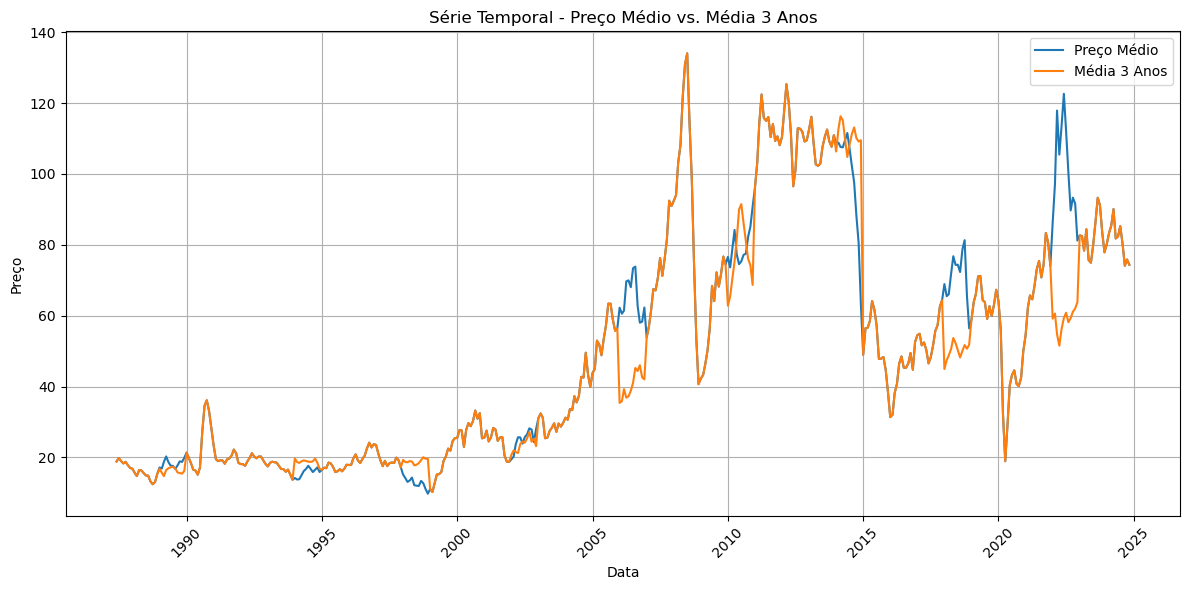

In [ ]:
# prompt: utilizando o df_filtrado construa o gráfico da serie temporal com os campos preco_medio e media_3_anos

import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado.index, df_filtrado['preco_medio'], label='Preço Médio')
plt.plot(df_filtrado.index, df_filtrado['media_3_anos'], label='Média 3 Anos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Série Temporal - Preço Médio vs. Média 3 Anos')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

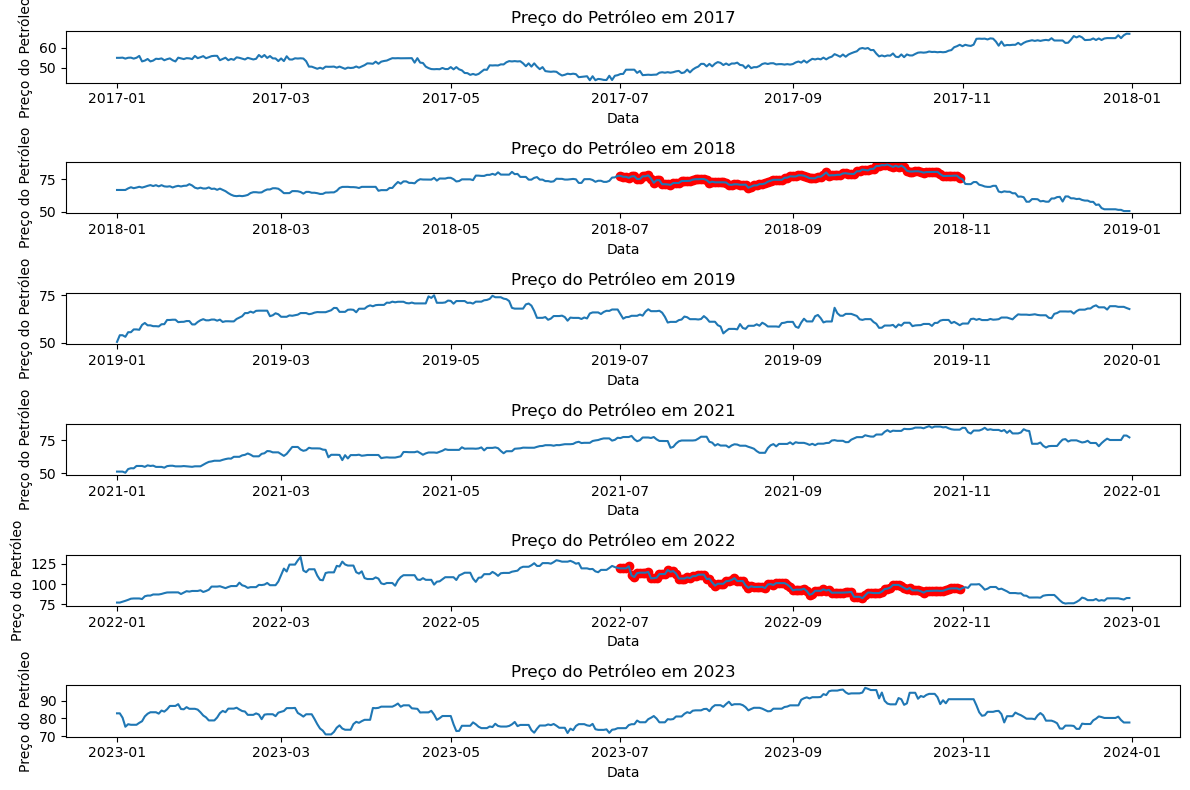

In [ ]:

# Filtra os dados para os anos desejados
anos = [2017,2018,2019,2021,2022,2023]  #anos_eleicoes[-2:]

fig, axs = plt.subplots(len(anos), 1, figsize=(12, 8)) # Define o layout dos gráficos

for i, ano in enumerate(anos):
    df_ano = df_dados_transformados[df_dados_transformados['ano'] == ano]

    # Cria o gráfico
    axs[i].plot(df_ano['data'], df_ano['preco'], label=f'Preço do Petróleo {ano}')

    # Adiciona marcadores para os meses de período eleitoral
    eleitoral_months = df_ano[df_ano['periodo_eleitoral'] == 1]
    axs[i].scatter(eleitoral_months['data'], eleitoral_months['preco'], color='red', label='Período Eleitoral')

    # Configurações do gráfico
    axs[i].set_xlabel('Data')
    axs[i].set_ylabel('Preço do Petróleo')
    axs[i].set_title(f'Preço do Petróleo em {ano}')
    #axs[i].tick_params(axis='x', rotation=45)
    #axs[i].legend(title='Meses de Período Eleitoral: Julho, Agosto, Setembro e Outubro')

plt.tight_layout()
plt.show()


## 6 - Visualização dos dados - Séries Temporais


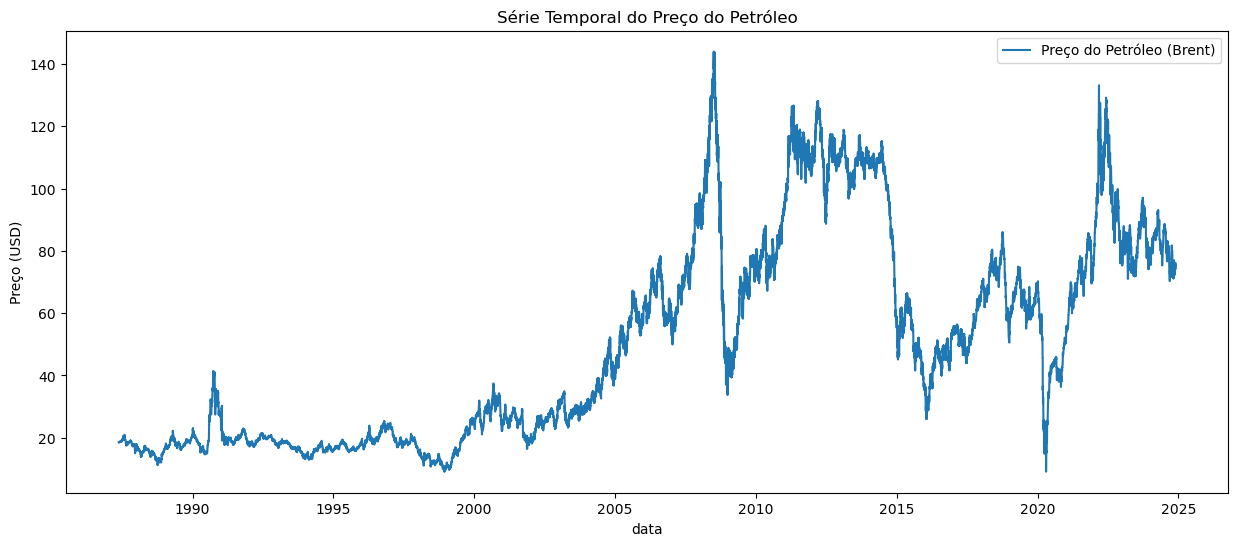

In [ ]:
# Plotando o grafico de todos os anos
plt.figure(figsize=(15, 6))
plt.plot(df_ipea['preco'], label='Preço do Petróleo (Brent)')
plt.title('Série Temporal do Preço do Petróleo')
plt.xlabel('data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()


### 6.1 - Decomposição da série período de **20 anos**

- Vamos trabalhar em cima dos ultimos 20 anos onde ouve uma maior oscilação dos valores

In [ ]:
# Criando um novo df com base nos ultimos 20 anos
df_ipea_20a = df_ipea[(df_ipea.index.year >= 2004) & (df_ipea.index.year <= 2024)]
df_ipea_20a

preco
data             
2004-01-01  30.30
2004-01-02  29.17
2004-01-03  30.10
2004-01-04  30.30
2004-01-05  32.30
...           ...
2024-11-21  75.09
2024-11-22  76.10
2024-11-23  76.10
2024-11-24  76.10
2024-11-25  74.27

[7635 rows x 1 columns]

In [ ]:
media_movel  = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').trend.to_frame()
sazonalidade = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').seasonal.to_frame()
residuo      = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_ipea_20a.index, y = df_ipea_20a.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent) - 20 Anos',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

**Analisando a decomposição da série temporal observamos que :**

> - **Tendência:**  Houve a maior alta no ano de 2008, e a maior queda no ano de 2020 - Será analisado nos topicos abaixo.

> - **Sazonalidade:**   A presença de um padrão repetitivo e regular ao longo dos anos. Isso sugere que fatores específicos a cada mês do ano podem influenciar significativamente o desempenho do índice.

> - **Ruído:** Podemos observar houve alguns pontos que causaram esse ruido .

In [ ]:
# Encontrando o Maior e Menor pico
maior_valor = df_ipea_20a.loc[df_ipea_20a['preco'].idxmax()]
menor_valor = df_ipea_20a.loc[df_ipea_20a['preco'].idxmin()]

print("Maior valor:")
print(maior_valor)

print("\nMenor valor:")
print(menor_valor)

Maior valor:
preco    143.95
Name: 2008-07-03 00:00:00, dtype: float64

Menor valor:
preco    9.12
Name: 2020-04-21 00:00:00, dtype: float64


### 6.2 - Analisando o grafico da media dos meses do anos de 2008 - Maior Variação

C:\Users\victo\AppData\Local\Temp\ipykernel_900\1269765176.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



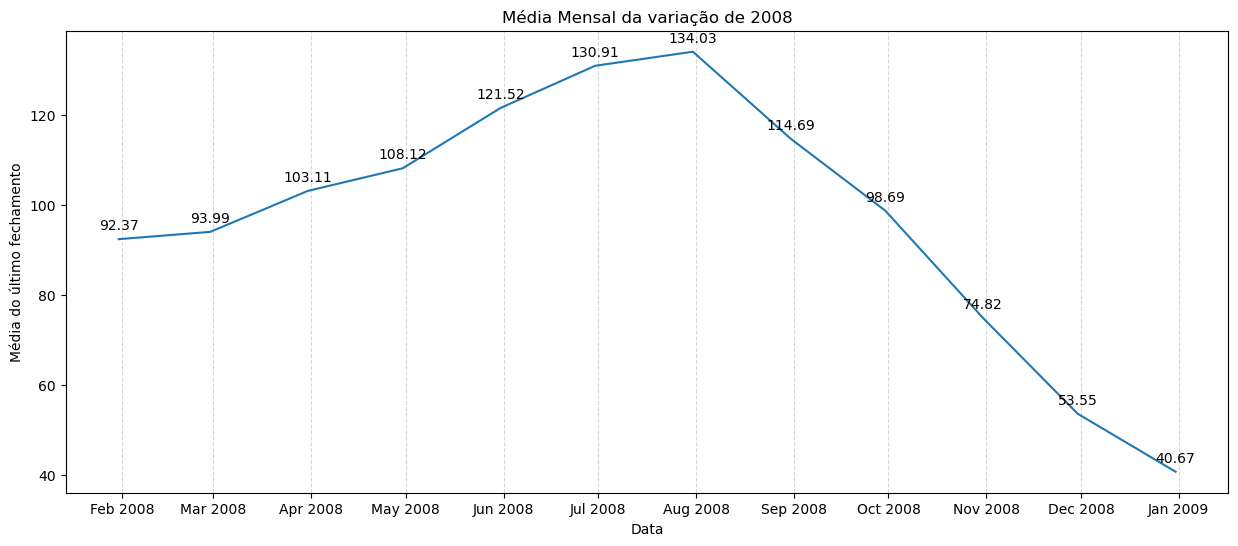

In [ ]:
# DataFrame contendo apenas os dados de 2008 para analisar o maior pico
df_ipea_2008 = df_ipea_20a[df_ipea_20a.index.year == 2008]

# Resample para média mensal
df_ipea_2008_resampled_monthly = df_ipea_2008['preco'].resample('M').mean()

# Plotar os dados mensais de 2008
plt.figure(figsize=(15, 6))
plt.plot(df_ipea_2008_resampled_monthly.index, df_ipea_2008_resampled_monthly)
plt.title('Média Mensal da variação de 2008')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2008_resampled_monthly.index, df_ipea_2008_resampled_monthly):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,7), ha='center', fontsize=10, color='black')

plt.show()


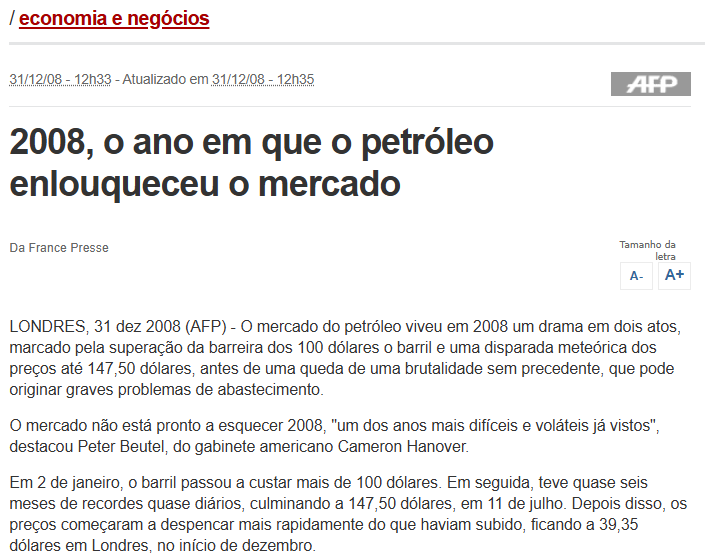




[**2008 - O ano em que o petróleo enlouqueceu o mercado**](https://g1.globo.com/Noticias/Economia_Negocios/0,,MUL940136-9356,00-O+ANO+EM+QUE+O+PETROLEO+ENLOUQUECEU+O+MERCADO.html#:~:text=LONDRES%2C%2031%20dez%202008%20%28AFP%29%20-%20O%20mercado,precedente%2C%20que%20pode%20originar%20graves%20problemas%20de%20abastecimento.
)

### 6.3 - Analisando a média dos meses do anos de 2020 - Menor Media

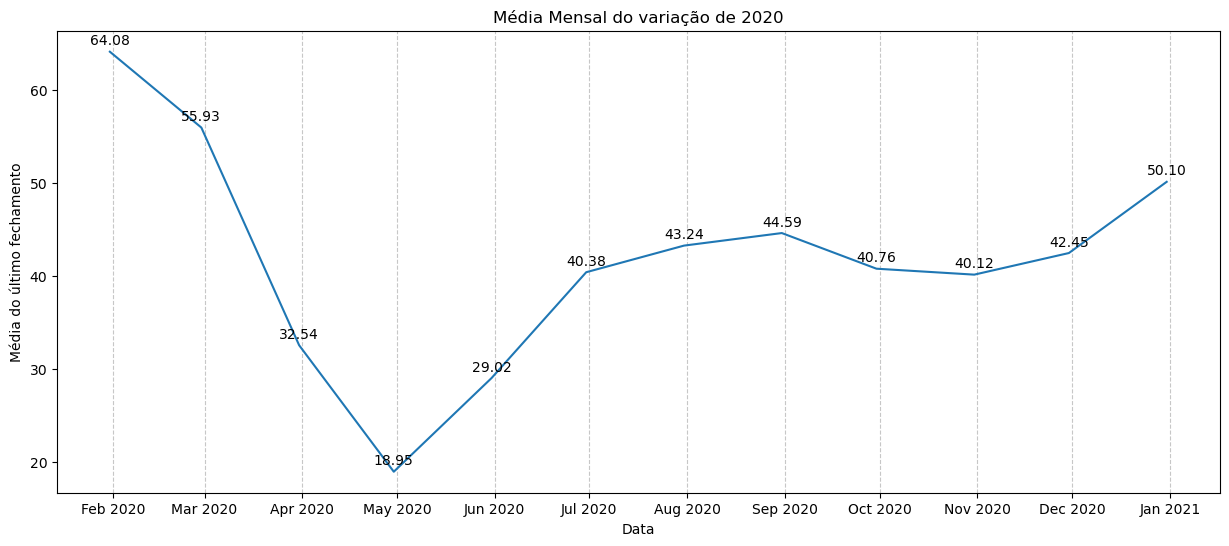

In [ ]:
# DataFrame contendo apenas os dados de 2020 para analisar o menor pico
df_ipea_2020 = df_ipea_20a[df_ipea_20a.index.year == 2020]

# Resample para média mensal
df_ipea_2020_resampled_mes = df_ipea_2020['preco'].resample('ME').mean()

# Plotar os dados mensais de 2020
plt.figure(figsize=(15, 6))
plt.plot(df_ipea_2020_resampled_mes.index, df_ipea_2020_resampled_mes)
plt.title('Média Mensal do variação de 2020')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2020_resampled_mes.index, df_ipea_2020_resampled_mes):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

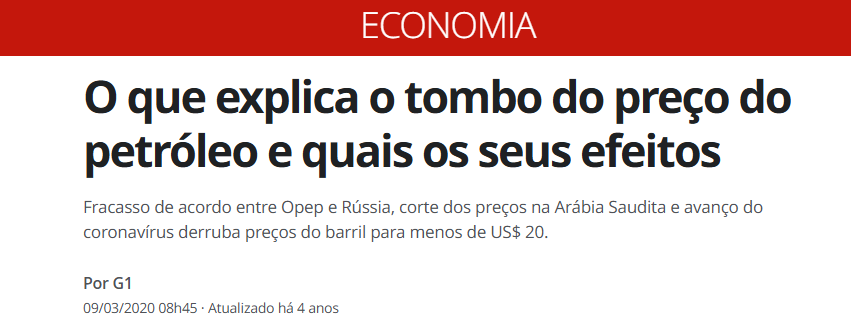


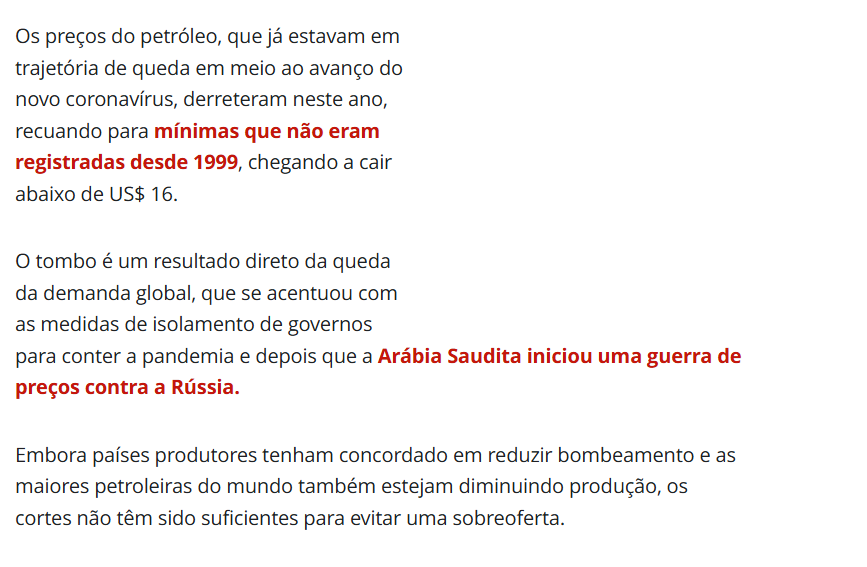

[**2020 - Covid-19 e Queda da demanda global**](https://g1.globo.com/economia/noticia/2020/03/09/o-que-explica-o-tombo-do-preco-do-petroleo-e-quais-os-seus-efeitos.ghtml)

### 6.4 - Analisando a Media dos meses do ano atual

In [ ]:
# Selecionando somente o ano atual
df_ipea_2024 = df_ipea[df_ipea.index.year >= 2024]
df_ipea_2024

preco
data             
2024-01-01  77.69
2024-01-02  76.24
2024-01-03  77.18
2024-01-04  75.79
2024-01-05  78.31
...           ...
2024-11-21  75.09
2024-11-22  76.10
2024-11-23  76.10
2024-11-24  76.10
2024-11-25  74.27

[330 rows x 1 columns]

In [ ]:
media_movel  = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').trend.to_frame()
sazonalidade = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').seasonal.to_frame()
residuo      = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_ipea_2024.index, y = df_ipea_2024.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent) - 2024',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

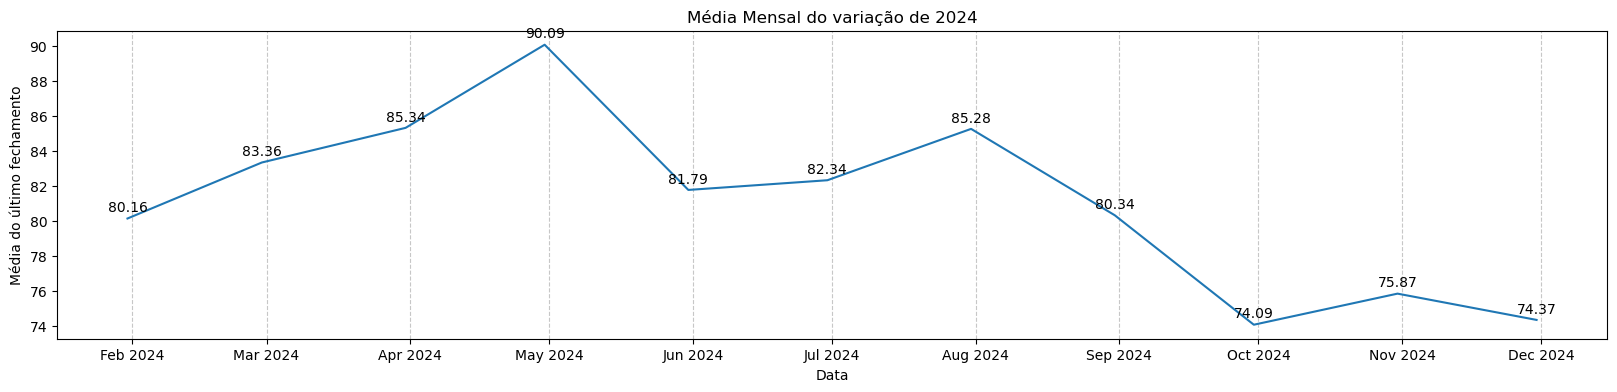

In [ ]:
# Resample para média mensal
df_ipea_2024_resampled_mes = df_ipea_2024['preco'].resample('ME').mean()

# Plotar os dados da media mensal de 2024
plt.figure(figsize=(20, 4))
plt.plot(df_ipea_2024_resampled_mes.index, df_ipea_2024_resampled_mes)
plt.title('Média Mensal do variação de 2024')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2024_resampled_mes.index, df_ipea_2024_resampled_mes):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

In [ ]:
df_ipea_2024_resampled_mes

data
2024-01-31    80.158710
2024-02-29    83.358621
2024-03-31    85.336129
2024-04-30    90.085000
2024-05-31    81.790000
2024-06-30    82.344000
2024-07-31    85.278065
2024-08-31    80.343226
2024-09-30    74.091000
2024-10-31    75.866774
2024-11-30    74.365600
Freq: ME, Name: preco, dtype: float64

## 7 - Analisando a Média Movel

### 7.1 - Teste ADF para estacionaria ou não estacionaria


In [ ]:
x = df_ipea_2024['preco'].values

In [ ]:
resultado = adfuller(x)

print("Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-value: {resultado[1]}")
print("Valores críticos: ")
print(f"É estacionária: {resultado[1] < 0.05}")

for key, value in resultado[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.831017471368193
P-value: 0.3651747053331349
Valores críticos: 
É estacionária: False
	1%: -3.4503836022181056
	5%: -2.8703653471616826
	10%: -2.571471939191249


- Analisando o resultado fica evidente que a serie ainda não esta estacionaria.

- Pois o valor do teste estatístico esta maior que os valores criticos, e nosso p-value não esta proximo do zero

### 7.2 - Transformando a série em estacionaria

In [ ]:
# Criando uma média móvel com base nos últimos 10 e 20 dias.
df_ipea_10_20 = df_ipea_2024

# Odernar por data
df_ipea_10_20 = df_ipea_10_20.sort_index(ascending=False)

#df_ipea_10_20['media_10_dias'] = df_ipea_10_20['preco'].rolling(10).mean() #média móvel em 10 dias
#df_ipea_10_20['media_20_dias'] = df_ipea_10_20['preco'].rolling(20).mean() #média móvel em 10 dias

df_ipea_10_20['media_10_dias'] = df_ipea_10_20['preco'].rolling(10, min_periods=1).mean().shift()
df_ipea_10_20['media_20_dias'] = df_ipea_10_20['preco'].rolling(20, min_periods=1).mean().shift()


df_ipea_10_20.head(30)

preco  media_10_dias  media_20_dias
data                                           
2024-11-25  74.27            NaN            NaN
2024-11-24  76.10      74.270000      74.270000
2024-11-23  76.10      75.185000      75.185000
2024-11-22  76.10      75.490000      75.490000
2024-11-21  75.09      75.642500      75.642500
2024-11-20  74.33      75.532000      75.532000
2024-11-19  74.32      75.331667      75.331667
2024-11-18  74.35      75.187143      75.187143
2024-11-17  73.45      75.082500      75.082500
2024-11-16  73.45      74.901111      74.901111
2024-11-15  73.45      74.756000      74.756000
2024-11-14  73.39      74.674000      74.637273
2024-11-13  72.86      74.403000      74.533333
2024-11-12  72.56      74.079000      74.404615
2024-11-11  72.19      73.725000      74.272857
2024-11-10  74.04      73.435000      74.134000
2024-11-09  74.04      73.406000      74.128125
2024-11-08  74.04      73.378000      74.122941
2024-11-07  75.73      73.347000      74.118333
2024-11-06  76.52      73.575000      74.203158
2024-11-05  76.98      73.882000      74.319000
2024-11-04  74.89      74.235000      74.454500
2024-11-03  73.63      74.385000      74.394000
2024-11-02  73.63      74.462000      74.270500
2024-11-01  73.63      74.569000      74.147000
2024-10-31  73.25      74.713000      74.074000
2024-10-30  73.21      74.634000      74.020000
2024-10-29  71.09      74.551000      73.964500
2024-10-28  71.87      74.256000      73.801500
2024-10-27  75.62      73.870000      73.722500

- Plotando p gráfico

In [ ]:
fig = px.line(
    df_ipea_10_20['preco'],
    template = template,
    color_discrete_sequence = ['#B22222']
)

fig.add_scatter(
    x = df_ipea_10_20.index,
    y =  df_ipea_10_20['media_10_dias'],
    name = 'Media 10 dias',
    marker = dict(color = '#00008B')
)

fig.add_scatter(
    x = df_ipea_10_20.index,
    y =  df_ipea_10_20['media_20_dias'],
    name = 'Media 20 dias',
    marker = dict(color = '#Ffa500')
)
fig.update_layout(
    title = 'Média Móvel Semanal X Média Móvel 2024 da Pontuação Ibovespa',
    xaxis_title = 'Período',
    yaxis_title = 'Valor Petroleo',
    legend_title = 'Legenda',
    width = 1100,
    height = 600,
    margin = dict(l = 100, r = 20, t = 80, b = 80)
)

fig.show()

In [ ]:
ma = df_ipea_10_20.rolling(7).mean()
ma = ma.rename(columns={'preco': 'Média Semanal'})

df_plot = pd.concat([df_ipea_10_20, ma], axis=1)
df_plot = df_plot.rename(columns={'preco': 'Fechamento Diário'})

fig = px.line(df_plot, x=df_plot.index, y=['Fechamento Diário', 'Média Semanal'])

fig.update_layout(
    title={
        "text" : "Preço do Petroleo",
        'x': 0.5,
        'xanchor': 'center'},
    xaxis_title="Data",
    yaxis_title="Valor do Fechamento",
    legend_title="Legenda",
    width = 1100,
    height = 600,
    margin = dict(l = 100, r = 20, t = 80, b = 80)
)

fig.show()

In [ ]:
df_log = np.log(df_ipea_10_20)
ma_log = df_log.rolling(7).mean()

df_s = (df_log - ma_log).fillna(0)

ma_s = df_s.rolling(7).mean()

std = df_s.rolling(7).std()

# gráfico com Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_s.index, y=df_s.iloc[:, 0], mode='lines', name='Log Ajustado'))
fig.add_trace(go.Scatter(x=ma_s.index, y=ma_s.iloc[:, 0], mode='lines', name='Média Móvel', line=dict(color='red')))
fig.add_trace(go.Scatter(x=std.index, y=std.iloc[:, 0], mode='lines', name='Desvio Padrão', line=dict(color='green')))

fig.update_layout(
            title={
                   'text': 'Gráfico com Médias Móveis X Desvio Padrão',
                   'x': 0.5,
                   'xanchor': 'center'
                  },
            xaxis_title='Data',
            yaxis_title='Valor',
            legend_title="Legenda",
            width = 1100,
            height = 600,
            margin = dict(l = 100, r = 20, t = 80, b = 80)
)
fig.show()

In [ ]:
X_s = df_s['preco'].values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")
print(f"É estacionária: {resultado[1] < 0.05}")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -8.443981529833062
P-Value: 1.7326804594142428e-13
Valores críticos:
É estacionária: False
	1%: -3.450632157720528
	5%: -2.870474482366864
	10%: -2.5715301325443787


In [ ]:
df_diff = df_s.diff(1)

ma_diff = df_diff.rolling(7).mean()

std_diff = df_diff.rolling(7).std()


# Criar o gráfico com Plotly
fig = go.Figure()

# Plotando as diferenças de primeira ordem, médias móveis e desvio padrão
fig.add_trace(go.Scatter(x=df_diff.index, y=df_diff.iloc[:, 0], mode='lines', name='Diferença de 1ª Ordem'))
fig.add_trace(go.Scatter(x=ma_diff.index, y=ma_diff.iloc[:, 0], mode='lines', name='Média Móvel (Diferença)', line=dict(color='red')))
fig.add_trace(go.Scatter(x=std_diff.index, y=std_diff.iloc[:, 0], mode='lines', name='Desvio Padrão (Diferença)', line=dict(color='green')))

fig.update_layout(
    title={
        'text': "Gráfico de Diferenças de 1ª Ordem com Médias Móveis e Desvio Padrão",
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Data',
    yaxis_title='Valor',
    width=1300,
    height=600,
    margin=dict(l=100, r=20, t=80, b=80)
)
fig.show()

X_diff = df_diff['preco'].dropna().values
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -8.153215980036997
P-Value: 9.571668196782805e-13
Valores críticos:
	1%: -3.451552879535732
	5%: -2.8708786756338407
	10%: -2.571745666091128


In [ ]:
lag_acf = acf(df_diff['preco'].dropna(), nlags=40)
lag_pacf = pacf(df_diff['preco'].dropna(), nlags=40)

In [ ]:
# Intervalo de confiança para o ACF/PACF
ci = 1.96/np.sqrt(len(df_s))

trace_acf = go.Scatter(x = np.arange(len(lag_acf)),y = lag_acf, mode='lines', name='ACF')
trace_pacf = go.Scatter(x = np.arange(len(lag_pacf)),y = lag_pacf, mode='lines', name='PACF')

# Linhas de intervalo de confiança superior e inferior
trace_ci_upper = go.Scatter(x = np.arange(len(lag_acf)),y = [ci]*len(lag_acf), mode='lines', name='Limite superior do intervalo de confiança', line=dict(dash='dash', color='gray'))
trace_ci_lower = go.Scatter(x = np.arange(len(lag_acf)),y = [-ci]*len(lag_acf), mode='lines', name='Limite superior do inferior de confiança', line=dict(dash='dash', color='gray'))


fig_acf = go.Figure(data=[trace_acf, trace_ci_upper, trace_ci_lower])
fig_pacf = go.Figure(data=[trace_pacf, trace_ci_upper, trace_ci_lower])

fig_acf.show()
fig_pacf.show()

<Figure size 1200x600 with 0 Axes>

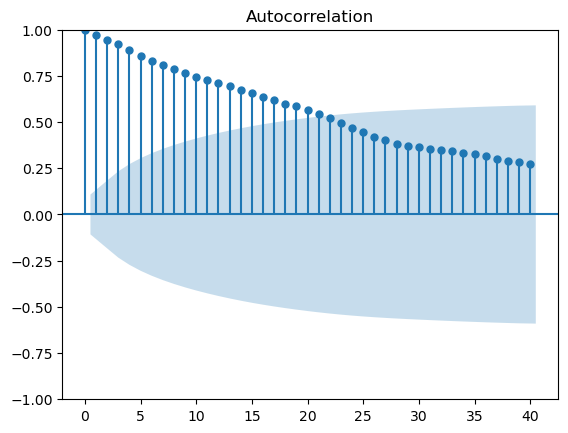

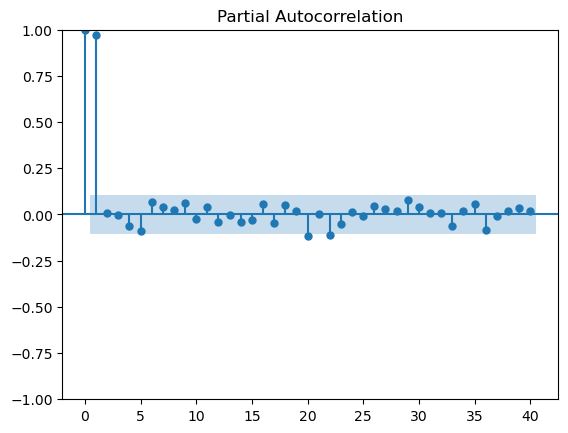

In [ ]:
plt.figure(figsize=(12, 6))

plot_acf(x,lags=40)
plot_pacf(x,lags=40)
plt.show()

In [ ]:
df_diff

preco  media_10_dias  media_20_dias
data                                              
2024-11-25       NaN            NaN            NaN
2024-11-24  0.000000       0.000000   0.000000e+00
2024-11-23  0.000000       0.000000   0.000000e+00
2024-11-22  0.000000       0.000000   0.000000e+00
2024-11-21  0.000000       0.000000   0.000000e+00
...              ...            ...            ...
2024-01-05  0.002854       0.000411  -7.293822e-05
2024-01-04 -0.024612       0.000843   7.082759e-04
2024-01-03  0.020524      -0.001884  -4.422577e-04
2024-01-02 -0.009049      -0.000034   4.281146e-04
2024-01-01  0.014699      -0.001077   9.669323e-07

[330 rows x 3 columns]

In [ ]:
df_diff.to_csv('df_diff.csv', index=False)

## - Machine

### - Criando métricas para validação dos modelos

- Erro Absoluto Médio (MAE)
- Erro Percentual Médio Absoluto (MAPE)
- Erro Quadrático Médio (MSE)



In [ ]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape

def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

In [ ]:
df_diff.reset_index(inplace = True)

In [ ]:
df_diff.reset_index(inplace = True)
df_ipea_prev = df_diff[['data', 'preco','media_10_dias']].rename(columns = {'data': 'ds', 'media_10_dias': 'y'})
df_ipea_prev.dropna(inplace = True)
df_ipea_prev.head(30)

ds     preco         y
1  2024-11-24  0.000000  0.000000
2  2024-11-23  0.000000  0.000000
3  2024-11-22  0.000000  0.000000
4  2024-11-21  0.000000  0.000000
5  2024-11-20  0.000000  0.000000
6  2024-11-19 -0.011539  0.000000
7  2024-11-18  0.000250 -0.000608
8  2024-11-17 -0.007115 -0.002947
9  2024-11-16  0.005063 -0.001878
10 2024-11-15  0.005063 -0.000543
11 2024-11-14  0.002454  0.000743
12 2024-11-13 -0.004394 -0.001484
13 2024-11-12 -0.000702 -0.001969
14 2024-11-11 -0.000901 -0.001985
15 2024-11-10  0.024161 -0.000772
16 2024-11-09 -0.001143  0.002485
17 2024-11-08 -0.001143  0.002276
18 2024-11-07  0.018085  0.002139
19 2024-11-06  0.003376  0.004702
20 2024-11-05 -0.002454  0.004544
21 2024-11-04 -0.032771  0.003782
22 2024-11-03 -0.016175  0.000182
23 2024-11-02  0.000793 -0.001006
24 2024-11-01  0.000793 -0.000864
25 2024-10-31 -0.000418 -0.000707
26 2024-10-30  0.005771 -0.003099
27 2024-10-29 -0.018014 -0.002400
28 2024-10-28  0.016792 -0.004005
29 2024-10-27  0.047052 -0.004219
30 2024-10-26 -0.003810  0.000095

In [ ]:
# Quantidade de linhas no DataFrame
total_linhas = len(df_ipea_prev)

# Dados de treino: todas as linhas exceto as últimas 7
treino = df_ipea_prev.iloc[:total_linhas - 10]

# Dados de validação: as últimas 7 linhas
valida = df_ipea_prev.iloc[total_linhas - 10:]

# h: número de datas únicas na validação
h = valida['ds'].nunique()

# Mostrando os resultados
print("Treino:\n", treino)
print("\nValidação:\n", valida)
print("\nh:", h)

Treino:
             ds     preco         y
1   2024-11-24  0.000000  0.000000
2   2024-11-23  0.000000  0.000000
3   2024-11-22  0.000000  0.000000
4   2024-11-21  0.000000  0.000000
5   2024-11-20  0.000000  0.000000
..         ...       ...       ...
315 2024-01-15 -0.001445 -0.000544
316 2024-01-14  0.003087  0.000576
317 2024-01-13  0.001459  0.000959
318 2024-01-12  0.001459  0.000877
319 2024-01-11  0.005468  0.001046

[319 rows x 3 columns]

Validação:
             ds     preco         y
320 2024-01-10 -0.021297  0.002365
321 2024-01-09 -0.002325 -0.000202
322 2024-01-08 -0.024691 -0.000896
323 2024-01-07  0.039794 -0.003932
324 2024-01-06  0.002854  0.002070
325 2024-01-05  0.002854  0.000411
326 2024-01-04 -0.024612  0.000843
327 2024-01-03  0.020524 -0.001884
328 2024-01-02 -0.009049 -0.000034
329 2024-01-01  0.014699 -0.001077

h: 10


In [ ]:
# Dados de treino
treino = df_ipea_prev.loc[df_ipea_prev['ds'] < '2024-07-13']

# Dados de validação (5 dias), quanto maior o período de predição, maior a largura de banda (maior o erro)
valida = df_ipea_prev.loc[(df_ipea_prev['ds'] >= '2024-07-13') & (df_ipea_prev['ds'] <= '2024-07-22')]
h = valida['data'].nunique()
h

KeyError: 'data'

### Arima

In [ ]:
# 3. Modelo de Previsão - ARIMA
# Separando os dados para treino e teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Treinando o modelo ARIMA
model = ARIMA(train['preco'], order=(5, 1, 0))  # Ajuste os parâmetros (p, d, q)
model_fit = model.fit()

# Previsões
forecast = model_fit.forecast(steps=len(test))
test['Forecast'] = forecast

# Avaliação do Modelo
rmse = np.sqrt(mean_squared_error(test['preco'], test['Forecast']))
print(f'RMSE do Modelo: {rmse}')

# Visualizando Previsões
plt.figure(figsize=(12, 6))
plt.plot(train['preco'], label='Treino')
plt.plot(test['preco'], label='Teste')
plt.plot(test['Forecast'], label='Previsões', linestyle='--')
plt.title('Modelo ARIMA - Previsões vs Dados Reais')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

# 4. Exportando o modelo para integração no Streamlit
import pickle
with open('modelo_arima.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

print("Modelo salvo como 'modelo_arima.pkl'")


### Sarimax

In [ ]:
# Preparar dados para Prophet
treino_prophet = treino.rename(columns={"data": "ds", "fechamento": "y"})
valida_prophet = valida.rename(columns={"data": "ds", "fechamento": "y"})

# Treinar modelo Prophet
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.add_regressor("abertura")
modelo_prophet.fit(treino_prophet)

# Criando o futuro para predição
future = modelo_prophet.make_future_dataframe(periods=len(valida))
future["abertura"] = pd.concat([treino["abertura"], valida["abertura"]], ignore_index=True)
forecast = modelo_prophet.predict(future)

# Criando as Previsões
preds = forecast[["ds", "yhat"]].tail(len(valida))
preds = preds.set_index("ds")
y_test = valida_prophet.set_index("ds")["y"]


metrics_prophet = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_prophet)

## streamlit


In [ ]:
df_st = df_ipea_20a.copy()
df_st = df_st.sort_index(ascending=False)
df_st = df_st.reset_index()  # Reseta o índice
df_st['mes'] = df_st['data'].dt.month
df_st['ano'] = df_st['data'].dt.year
df_st = df_st.sort_values(by='data', ascending=True)
df_st['variacao_%'] = round(df_st['preco'].pct_change() * 100, 2)
df_st.head()

In [ ]:
# Filtrar os dados do último ano
ultimo_ano = df_st['ano'].max()  # Obter o último ano
df_ultimo_ano = df_st[df_st['ano'] == ultimo_ano]

# Agrupar por mês e calcular a variação média
df_ultimo_ano_mensal = df_ultimo_ano.groupby(['ano', 'mes']).agg({'variacao_%': 'mean'}).reset_index()

# Plotar o gráfico da variação percentual por mês
plt.figure(figsize=(10,6))
plt.plot(df_ultimo_ano_mensal['mes'], df_ultimo_ano_mensal['variacao_%'], marker='o', linestyle='-', color='b')
plt.title(f'Variação Percentual Mensal do Preço do Petróleo em {ultimo_ano}')
plt.xlabel('Mês')
plt.ylabel('Variação (%)')
plt.grid(True)

meses_unicos = sorted(df_ultimo_ano_mensal['mes'].unique())

meses_labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
][0:len(meses_unicos)]

plt.xticks(meses_unicos, meses_labels)
plt.tight_layout()
plt.show()